In [68]:
### LIBRARIES
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import portfolioAllocation
import importlib
import allocationModel
import json


### PRICE TIME SERIES DATAFRAME
price_series = pd.read_csv("/Users/andrei/Documents/asset-allocation-data/processed/2024-06-02/all_markets_2024-06-02.csv")
price_series['DATE'] = pd.to_datetime(price_series['DATE'])
price_series.set_index('DATE', inplace=True)
price_series = price_series.loc[price_series.index > "2007-01-01"]
print("Markets: ", price_series.columns)
portfolioAllocation.validate(price_series)

### GENERATING LOG RETURNS
log_returns = portfolioAllocation.getLogReturns(price_series)
risk_free_rate = 0.03
expected_returns = portfolioAllocation.getExpectedReturns(log_returns, calendarized = True) * 252
cov_matrix = portfolioAllocation.getCovarianceMatrix(log_returns, calendarized = True) * 252

### FOREX TIME SERIES DATAFRAME
fx_series = pd.read_csv("/Users/andrei/Documents/asset-allocation-data/processed/2024-06-02/FX_2024-06-02.csv")
fx_series['DATE'] = pd.to_datetime(fx_series['DATE'])
fx_series.set_index('DATE', inplace=True)

### MARKETS MAPPING JSON
with open('/Users/andrei/Documents/GitHub/asset-allocation/markets_mapping.JSON', 'r') as file:
    market_mapping = json.load(file)
    ### MARKETS MAPPING JSON
with open('/Users/andrei/Documents/GitHub/asset-allocation/fx_mapping.JSON', 'r') as file:
    forex_mapping = json.load(file)

Markets:  Index(['AFRICA_SOVEREIGN_BOND', 'CHINA_GOV_BOND', 'EURO_SOVEREIGN_BOND',
       'USA_GOV_BOND', 'ASIA_PACIFIC_LARGE_MID_CAP',
       'EMERGING_MARKETS_LARGE_MID_CAP', 'EUROPE_LARGE_CAP',
       'HONG_KONG_LARGE_CAP', 'USA_LARGE_CAP', 'USA_SMALL_CAP'],
      dtype='object')
Warning! Number of rows with missing values (3000) is higher than 20.0% of total rows (4527)
Percentage of missing rows: 66.0%
+---------------------+--------+-------------+
|      Test name      | Passed | Test values |
+---------------------+--------+-------------+
| Missing values test | False  |  0.66 > 0.2 |
|  Time series length |  True  |  1527 > 756 |
+---------------------+--------+-------------+


In [70]:
importlib.reload(portfolioAllocation)
print(price_series["HONG_KONG_LARGE_CAP"].head())
converted = portfolioAllocation.forexPriceTransformation(pricesTimeSeriesDf=price_series, forexTimeSeriesDf=fx_series, markets_mapping=market_mapping)
print(converted["HONG_KONG_LARGE_CAP"].head())
print(price_series["HONG_KONG_LARGE_CAP"].head())

DATE
2007-01-02    20310.179688
2007-01-03    20413.390625
2007-01-04    20025.580078
2007-01-05    20211.279297
2007-01-08    20029.660156
Name: HONG_KONG_LARGE_CAP, dtype: float64
DATE
2007-01-02    157980.700550
2007-01-03    158948.865634
2007-01-04    155955.209232
2007-01-05    157649.996606
2007-01-08    156109.168552
Name: HONG_KONG_LARGE_CAP, dtype: float64
DATE
2007-01-02    20310.179688
2007-01-03    20413.390625
2007-01-04    20025.580078
2007-01-05    20211.279297
2007-01-08    20029.660156
Name: HONG_KONG_LARGE_CAP, dtype: float64


In [4]:
mkt_ccy = portfolioAllocation.forexPriceTransformation(price_series, None, market_mapping)
print(mkt_ccy)

                           market currency
0                    USA_GOV_BOND      USD
1           AFRICA_SOVEREIGN_BOND      USD
2                  CHINA_GOV_BOND      CNY
3             EURO_SOVEREIGN_BOND      USD
4                   USA_LARGE_CAP      USD
5                   USA_SMALL_CAP      USD
6                EUROPE_LARGE_CAP      EUR
7             HONG_KONG_LARGE_CAP      HKD
8      ASIA_PACIFIC_LARGE_MID_CAP      USD
9  EMERGING_MARKETS_LARGE_MID_CAP      USD


In [303]:
### INSTANTIATING MARKOWITZ MODEL
importlib.reload(allocationModel)
my_model = allocationModel.markowitzModel(expected_returns = expected_returns,
                                          cov_matrix = cov_matrix,
                                          risk_free_rate = risk_free_rate,
                                          markets_mapping = market_mapping)

In [295]:
### DEFINING ALLOCATION CONSTRAINTS
allocation_constraints = [
    {"market": "USA_LARGE_CAP", "sign": "<", "percentage": "0.7", "constraint_type": "relative"}
]
#print(allocation_constraints)

new_constraints = pd.DataFrame(allocation_constraints)
allocation_constraints = []
for market in expected_returns.index:
    
    
    allocation_constraints.append({
        "market": market,
        "sign": ">",
        "percentage": "0.15",
        "constraint_type": "relative"
    })
allocation_constraints = pd.DataFrame(allocation_constraints)
print(allocation_constraints)

                           market sign percentage constraint_type
0           AFRICA_SOVEREIGN_BOND    >       0.15        relative
1                  CHINA_GOV_BOND    >       0.15        relative
2             EURO_SOVEREIGN_BOND    >       0.15        relative
3                    USA_GOV_BOND    >       0.15        relative
4      ASIA_PACIFIC_LARGE_MID_CAP    >       0.15        relative
5  EMERGING_MARKETS_LARGE_MID_CAP    >       0.15        relative
6                EUROPE_LARGE_CAP    >       0.15        relative
7             HONG_KONG_LARGE_CAP    >       0.15        relative
8                   USA_LARGE_CAP    >       0.15        relative
9                   USA_SMALL_CAP    >       0.15        relative


0
1
2
3
4
5
6
7
8
9


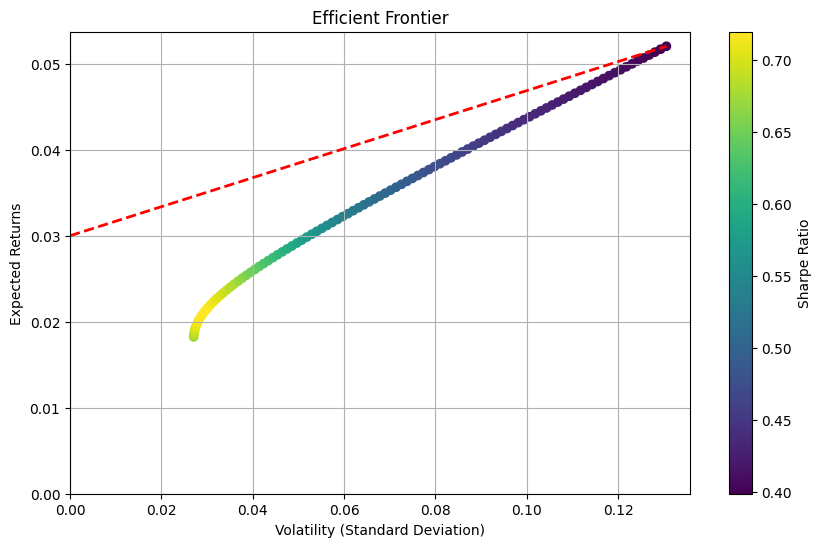

In [304]:
pf = my_model.calculateEfficientFrontier(short_selling=False, allocation_constraints=allocation_constraints)

# Calculate Sharpe ratio for each portfolio
pf['sharpe_ratio'] = (pf['returns'] - risk_free_rate) / pf['volatility']

# Find portfolio with maximum Sharpe ratio
max_sharpe_portfolio = pf.iloc[pf['sharpe_ratio'].idxmax()]

# Calculate slope of the line from (0, risk_free) to the maximum Sharpe portfolio
slope = max_sharpe_portfolio['returns'] / max_sharpe_portfolio['volatility']

# Plotting the Efficient Frontier
plt.figure(figsize=(10, 6))
plt.scatter(pf['volatility'], pf['returns'], c=pf['returns'] / pf['volatility'], marker='o')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.plot([0, max_sharpe_portfolio['volatility']], [risk_free_rate, max_sharpe_portfolio['returns']], color='red', linestyle='--', linewidth=2)

plt.show()

0
1
2
3
4
5
6
7
8
9


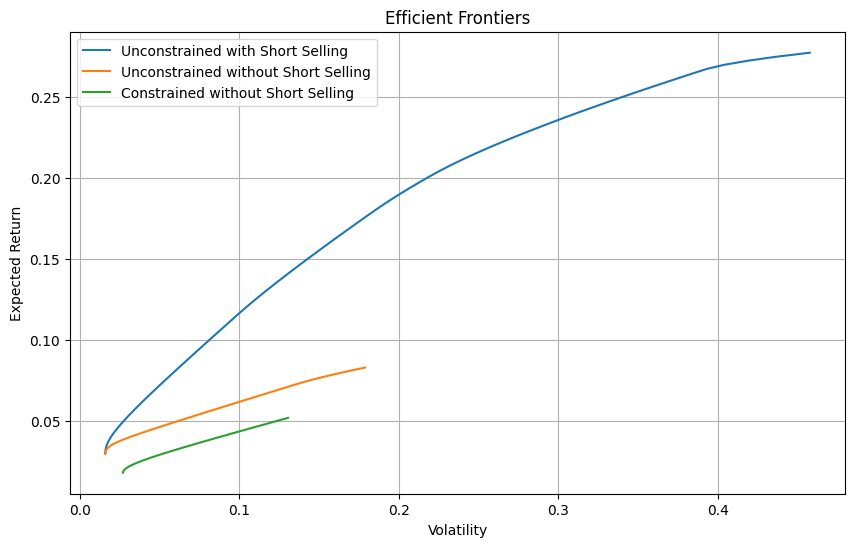

In [305]:
# Calculate efficient frontiers for different scenarios
efficient_frontier_unconstrained_short = my_model.calculateEfficientFrontier(short_selling=True)
efficient_frontier_unconstrained_no_short = my_model.calculateEfficientFrontier(short_selling=False)
efficient_frontier_constrained_no_short = my_model.calculateEfficientFrontier(short_selling=False, allocation_constraints=allocation_constraints)

# Function to plot efficient frontiers
def plot_efficient_frontier(efficient_frontier, title, ax):
    ax.plot(efficient_frontier['volatility'], efficient_frontier['returns'], label=title)
    ax.set_xlabel('Volatility')
    ax.set_ylabel('Expected Return')
    ax.legend()

# Plot the efficient frontiers
fig, ax = plt.subplots(figsize=(10, 6))

plot_efficient_frontier(efficient_frontier_unconstrained_short, 'Unconstrained with Short Selling', ax)
plot_efficient_frontier(efficient_frontier_unconstrained_no_short, 'Unconstrained without Short Selling', ax)
plot_efficient_frontier(efficient_frontier_constrained_no_short, 'Constrained without Short Selling', ax)

plt.title('Efficient Frontiers')
plt.grid(True)
plt.show()

In [291]:
pf['weights']

0     [0.14999999998887198, 0.5499999999699722, 0.15...
1     [0.1484848484738689, 0.544444444438301, 0.1484...
2     [0.14696969692149872, 0.5388888886162579, 0.14...
3     [0.14545454541363445, 0.5333333330905036, 0.14...
4     [0.14393939387756277, 0.5277777774615847, 0.14...
                            ...                        
95    [0.006060606067738947, 0.02222222224810056, 0....
96    [0.0045454545532004125, 0.016666666695487144, ...
97    [0.0030303030366994428, 0.011111111134635381, ...
98    [0.0015151514840922545, 0.005555555441564169, ...
99    [7.279649428781544e-14, 2.6680724211127526e-13...
Name: weights, Length: 100, dtype: object

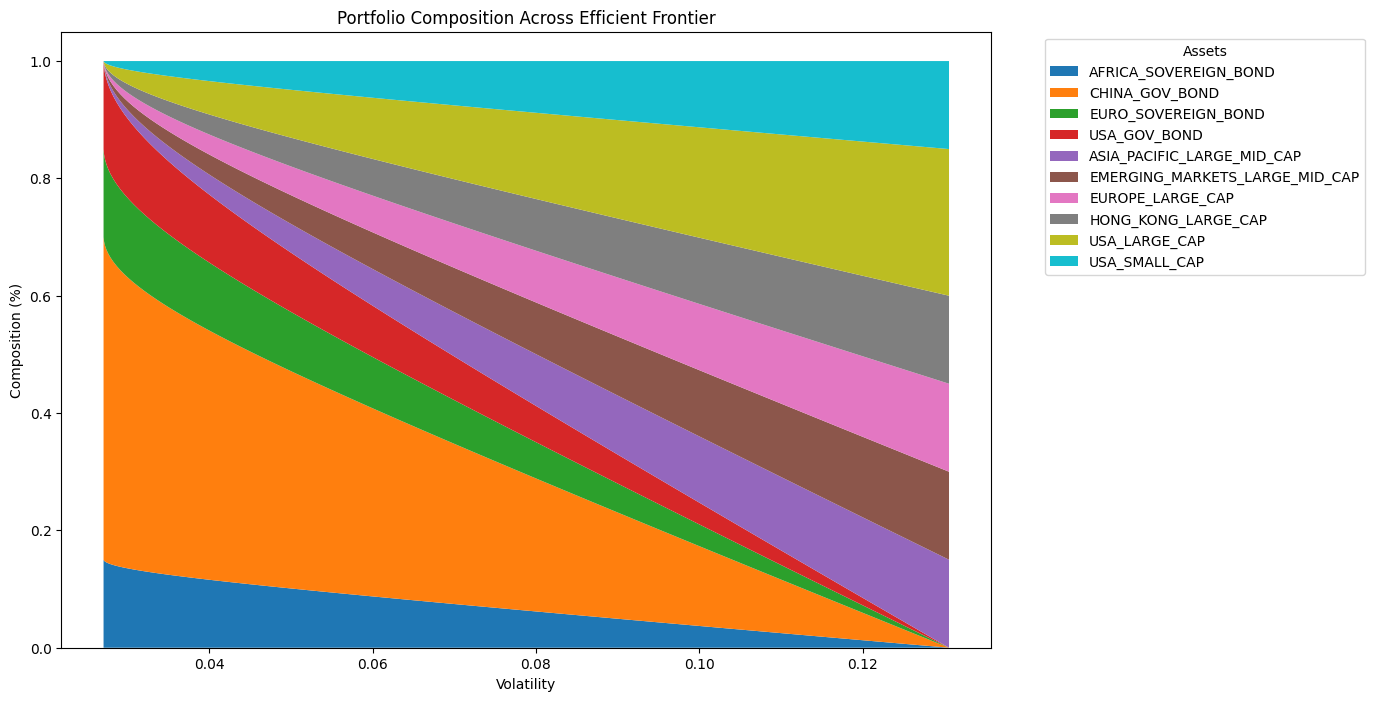

In [292]:
# Assuming the provided weights data is in pf DataFrame
# and the DataFrame also contains a 'volatility' column
weights = pf['weights']
volatilities = pf['volatility']

# Convert the list of weights to a DataFrame for easier plotting
weights_df = pd.DataFrame(weights.tolist())

# Asset names from the expected_returns Series
asset_names = expected_returns.index

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Create stackplot
ax.stackplot(volatilities, weights_df.T, labels=asset_names)

# Adding labels and title
ax.set_xlabel('Volatility')
ax.set_ylabel('Composition (%)')
ax.set_title('Portfolio Composition Across Efficient Frontier')

# Adding legend
ax.legend(title='Assets', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()

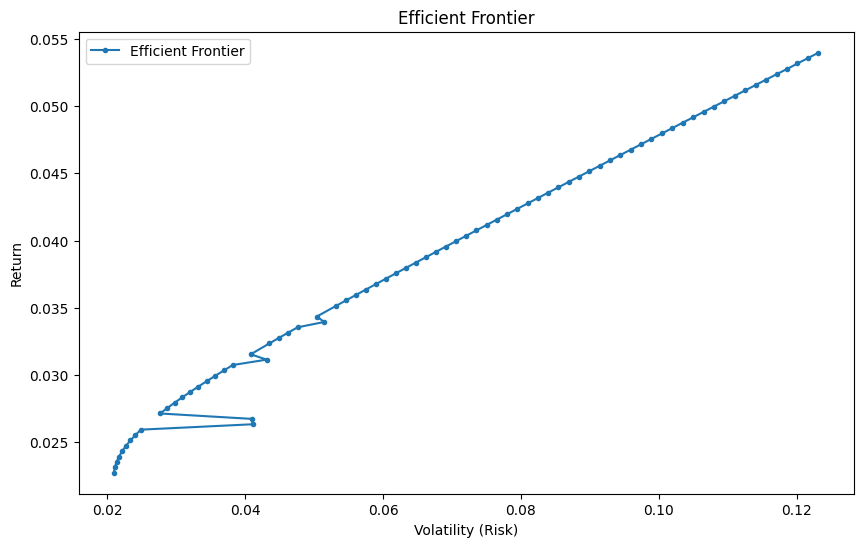

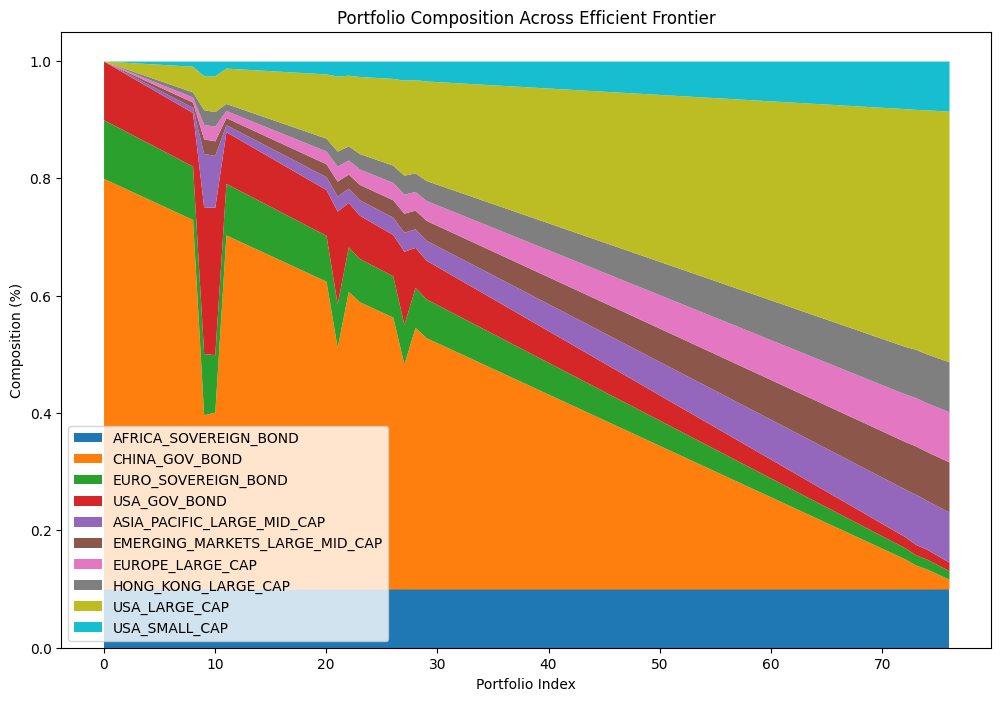

In [277]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def portfolio_returns(weights, expected_returns):
    return np.dot(weights, expected_returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def markowitz_optimization(expected_returns, cov_matrix, min_weight=0, num_portfolios=100):
    num_assets = len(expected_returns)
    results = {'returns': [], 'volatility': [], 'weights': []}
    
    # Constraints: weights sum to 1
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'ineq', 'fun': lambda x: x[[0]] - 0.1 * np.sum(x[[0,1,2,3]])},
                   {'type': 'ineq', 'fun': lambda x: x[[1]] - 0.1 * np.sum(x[[0,1,2,3]])},
                   {'type': 'ineq', 'fun': lambda x: x[[2]] - 0.1 * np.sum(x[[0,1,2,3]])},
                   {'type': 'ineq', 'fun': lambda x: x[[3]] - 0.1 * np.sum(x[[0,1,2,3]])},
                   {'type': 'ineq', 'fun': lambda x: x[[4]] - 0.1 * np.sum(x[[4,5,6,7,8,9]])},
                   {'type': 'ineq', 'fun': lambda x: x[[5]] - 0.1 * np.sum(x[[4,5,6,7,8,9]])},
                   {'type': 'ineq', 'fun': lambda x: x[[6]] - 0.1 * np.sum(x[[4,5,6,7,8,9]])},
                   {'type': 'ineq', 'fun': lambda x: x[[7]] - 0.1 * np.sum(x[[4,5,6,7,8,9]])},
                   {'type': 'ineq', 'fun': lambda x: x[[8]] - 0.1 * np.sum(x[[4,5,6,7,8,9]])},
                   {'type': 'ineq', 'fun': lambda x: x[[9]] - 0.1 * np.sum(x[[4,5,6,7,8,9]])}]
    
    # Bounds for each weight: each must be at least min_weight
    bounds = tuple((min_weight, 1) for _ in range(num_assets))

    # Minimum variance portfolio
    min_vol_result = minimize(lambda weights: portfolio_volatility(weights, cov_matrix),
                              num_assets * [1. / num_assets],
                              method='SLSQP',
                              bounds=bounds,
                              constraints=constraints)
    min_volatility = portfolio_volatility(min_vol_result.x, cov_matrix)
    
    # Maximum return portfolio
    max_ret_result = minimize(lambda weights: -portfolio_returns(weights, expected_returns),
                              num_assets * [1. / num_assets],
                              method='SLSQP',
                              bounds=bounds,
                              constraints=constraints)
    max_return = -max_ret_result.fun

    # Generate target returns between min return and max return
    min_return = portfolio_returns(min_vol_result.x, expected_returns)
    target_returns = np.linspace(min_return, max_return, num_portfolios)

    for target_return in target_returns:
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x: portfolio_returns(x, expected_returns) - target_return},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'ineq', 'fun': lambda x: x[[0]] - 0.1 * np.sum(x[[0,1,2,3]])},
            {'type': 'ineq', 'fun': lambda x: x[[1]] - 0.1 * np.sum(x[[0,1,2,3]])},
            {'type': 'ineq', 'fun': lambda x: x[[2]] - 0.1 * np.sum(x[[0,1,2,3]])},
            {'type': 'ineq', 'fun': lambda x: x[[3]] - 0.1 * np.sum(x[[0,1,2,3]])},
            {'type': 'ineq', 'fun': lambda x: x[[4]] - 0.1 * np.sum(x[[4,5,6,7,8,9]])},
            {'type': 'ineq', 'fun': lambda x: x[[5]] - 0.1 * np.sum(x[[4,5,6,7,8,9]])},
            {'type': 'ineq', 'fun': lambda x: x[[6]] - 0.1 * np.sum(x[[4,5,6,7,8,9]])},
            {'type': 'ineq', 'fun': lambda x: x[[7]] - 0.1 * np.sum(x[[4,5,6,7,8,9]])},
            {'type': 'ineq', 'fun': lambda x: x[[8]] - 0.1 * np.sum(x[[4,5,6,7,8,9]])},
            {'type': 'ineq', 'fun': lambda x: x[[9]] - 0.1 * np.sum(x[[4,5,6,7,8,9]])}
        ]
        
        result = minimize(lambda weights: portfolio_volatility(weights, cov_matrix),
                          num_assets * [1. / num_assets],
                          method='SLSQP',
                          bounds=bounds,
                          constraints=constraints)
        
        if result.success:
            results['returns'].append(target_return)
            results['volatility'].append(portfolio_volatility(result.x, cov_matrix))
            results['weights'].append(result.x)
    
    efficient_frontier = pd.DataFrame(results)
    return efficient_frontier

# Example data (replace with your actual data)


# Perform optimization to generate efficient frontier
efficient_frontier = markowitz_optimization(expected_returns, cov_matrix)

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(efficient_frontier['volatility'], efficient_frontier['returns'], 'o-', markersize=3, label='Efficient Frontier')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.legend()
plt.show()

# Plot the portfolio compositions
weights_df = pd.DataFrame(efficient_frontier['weights'].tolist(), columns=expected_returns.index)

fig, ax = plt.subplots(figsize=(12, 8))
weights_df.plot(kind='area', ax=ax, stacked=True, linewidth=0)
ax.set_xlabel('Portfolio Index')
ax.set_ylabel('Composition (%)')
ax.set_title('Portfolio Composition Across Efficient Frontier')
plt.show()


In [239]:
tmp = [1,2,3]
print(*tmp)

1 2 3
